In [2]:
import cv2
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
from skimage.morphology import binary_dilation
from scipy.ndimage import imread # For reading gifs
%matplotlib inline

plt.style.use('bmh')

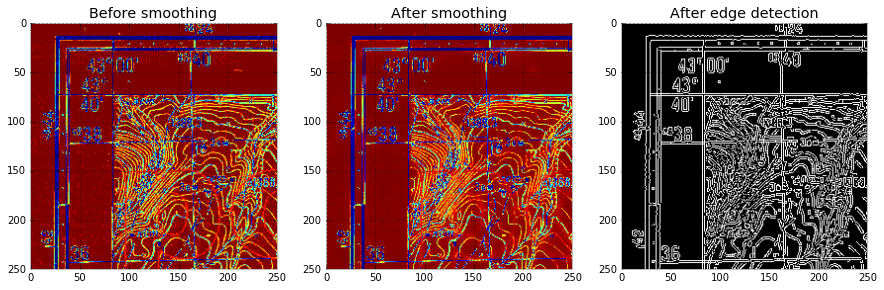

In [9]:
img_fp = './k38_lom_imgs/100k--k38-015.gif'
img = imread(img_fp)

gray = cv2.cvtColor(img.copy(), cv2.COLOR_RGB2GRAY)
smoothed = cv2.bilateralFilter(gray.copy(), 10, 30, 12)

f, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(gray[:250, :250]); axs[0].set_title('Before smoothing');
axs[1].imshow(smoothed[:250, :250]); axs[1].set_title('After smoothing');
edges = cv2.Canny(smoothed.copy(), 110, 230)
axs[2].imshow(edges[:250, :250], cmap='gray'); axs[2].set_title('After edge detection');

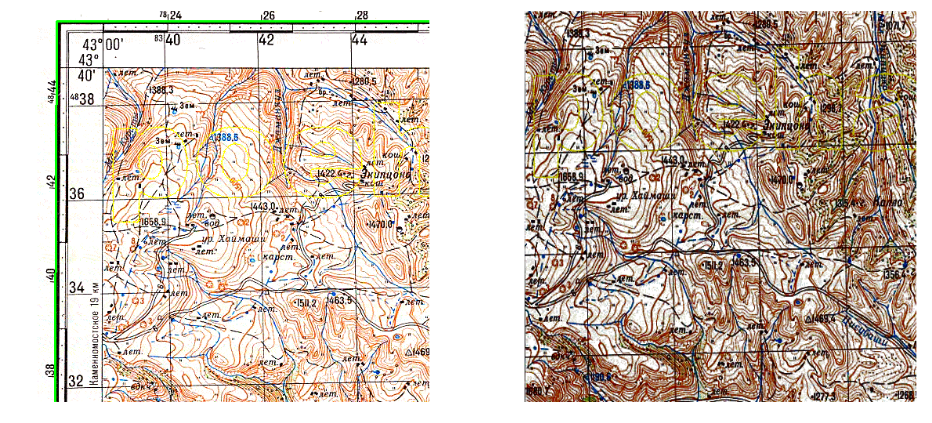

In [350]:
dilated = binary_dilation(edges)
_, cnts, hier = cv2.findContours(dilated.astype('uint8'), mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)
border = sorted(cnts, key=cv2.contourArea, reverse=True)[0]
perimeter = cv2.arcLength(border, True)
border_contour = [cv2.approxPolyDP(border, 0.1*perimeter, True)]
box_pts = np.reshape(border_contour, [4, 2])
cbox_pts = box_pts - np.mean(box_pts, axis=0)
tl = box_pts[np.argmax(-cbox_pts[:, 0] - cbox_pts[:, 1])] # --
tr = box_pts[np.argmax(-cbox_pts[:, 0] + cbox_pts[:, 1])]# -+
br = box_pts[np.argmax(cbox_pts[:, 0] + cbox_pts[:, 1])]# ++
bl = box_pts[np.argmax(cbox_pts[:, 0] - cbox_pts[:, 1])]# +-
src = np.array([tl, tr, br, bl]).astype('float32')
maxWidth = int( max(norm(tr - tl), norm(br - bl)) )
maxHeight = int( max(norm(tl - bl), norm(tr - br)) )

dst = np.array([
        [0, 0], # tl
        [0, maxHeight-1], # tr
        [maxWidth-1, maxHeight-1],
        [maxWidth-1, 0]
    ], dtype='float32')

M = cv2.getPerspectiveTransform(src, dst)
warp = cv2.warpPerspective(img.copy(), M, (maxWidth, maxHeight))
BORDER_H = 66
BORDER_W = 56
cropped_img = warp[BORDER_H:-BORDER_H, BORDER_W:-BORDER_W]
cropped_img = cv2.cvtColor(cropped_img, cv2.COLOR_RGB2YCrCb)
cropped_img[:, :, 0] = cv2.equalizeHist(cropped_img[:, :, 0])
cropped_img = cv2.cvtColor(cropped_img, cv2.COLOR_YCrCb2RGB)

dst = np.zeros(gray.shape)
dst = cv2.drawContours(img.copy(), border_contour, -1, color=[0, 255, 0], thickness=2)
f, axs = plt.subplots(1, 2, figsize=(16, 7), sharey=True);
axs[0].imshow(dst[:500, :500]); axs[1].imshow(cropped_img[:500, :500])
axs[1].axis('off'); axs[0].axis('off');